In [35]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [45]:
## loading training dataset and testing dataset
train_bin = pd.read_csv('TrainingDataBinary.csv',header=None)
test_bin = pd.read_csv('TestingDataBinary.csv',header=None)
train_bin.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,...,0,0,0,0,0,0,0,0,0,0
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,...,0,0,0,0,0,0,0,0,0,0
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,...,0,0,0,0,0,0,0,0,0,0
3,74.083443,130581.5902,-45.899649,130556.5169,-165.882741,130656.8100,72.152575,482.86107,-50.437475,499.15786,...,0,0,0,0,0,0,0,0,0,0
4,74.553268,131083.0556,-45.424094,131057.9823,-165.424375,131158.2754,72.118198,484.50906,-50.013486,497.69298,...,0,0,0,0,0,0,0,0,0,0


In [46]:
test_bin.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,12.118057,131810.1804,-107.847846,131183.3486,132.146986,131860.3269,10.089787,370.79775,-109.664122,369.88220,...,0,0,0,0,0,0,0,0,0,0
1,12.049302,131810.1804,-107.922330,131183.3486,132.066772,131860.3269,9.986654,370.79775,-109.899035,370.61464,...,0,0,0,0,0,0,0,0,0,0
2,12.043573,131810.1804,-107.928060,131183.3486,132.061042,131860.3269,9.958006,370.79775,-109.887576,370.61464,...,0,0,0,0,0,0,0,0,0,0
3,12.037843,131810.1804,-107.939519,131183.3486,132.061042,131860.3269,9.980925,370.79775,-109.870387,370.61464,...,0,0,0,0,0,0,0,0,0,0
4,11.946170,131810.1804,-108.031192,131183.3486,131.963639,131860.3269,9.860604,370.79775,-110.059463,370.79775,...,0,0,0,0,0,0,0,0,0,0


In [49]:
## extract data and label information from original dataset
x_full = train_bin.iloc[:,:-1]
y_full = train_bin.iloc[:,-1]

test_full = test_bin.values

In [50]:
## data preprocessing using standardization
scaler = StandardScaler()
scaler.fit(x_full)
x_full = scaler.transform(x_full)
test_full = scaler.transform(test_full)

In [51]:
x_full.shape

(6000, 128)

In [52]:
## split the original dataset into two parts, x_train,y_train will be used for training models
## x_test,y_test will be used for evaluted the model's performance.
x_train,x_test,y_train,y_test = train_test_split(x_full,y_full,test_size=0.2,random_state=1)

In [7]:
## res record the metrics accuracy,precision score, recall score, f1 score
## cm_list record the confusion matrix
## predprob record the predicted probability it will be used fo drawing roc curve.
## clapse record the running time for different algorithms
res = []
cm_list = {}
predprob = []
clapse = []

In [10]:
## logistic regression
start = time.time()
lr = LogisticRegression(random_state=1,solver='liblinear')
lr_param = {'penalty':['l1','l2','elasticnet'],'C':[0.001,0.01,0.1,1,10,100,1000]}
clf_lr = GridSearchCV(lr,lr_param,cv=5,n_jobs=-1)

clf_lr.fit(x_train,y_train)
print(f'Best logistic regression parameters are:{clf_lr.best_params_}')

best_lr = clf_lr.best_estimator_
best_lr.fit(x_train,y_train)

lr_pred = best_lr.predict(x_test)
lr_predprob = best_lr.predict_proba(x_test)

lr_acc = accuracy_score(y_test,lr_pred)
lr_precision = precision_score(y_test,lr_pred)
lr_recall = recall_score(y_test,lr_pred)
lr_f1 = f1_score(y_test,lr_pred)
lr_cm = confusion_matrix(y_test,lr_pred)

res.append([lr_acc,lr_precision,lr_recall,lr_f1])
cm_list['logistic regression'] = lr_cm
predprob.append(lr_predprob)
clapse.append(time.time()-start)

Best logistic regression parameters are:{'C': 1000, 'penalty': 'l1'}


In [11]:
lr_acc,lr_precision,lr_recall,lr_f1

(0.9125, 0.9323181049069373, 0.8944805194805194, 0.9130074565037283)

In [12]:
## decision tree
start = time.time()
dt = DecisionTreeClassifier(random_state=1)
dt_param = {'criterion':["gini","entropy "],
          'max_depth':range(4,30),
          'min_samples_split':range(1,4),
          'min_samples_leaf':range(1,4),
          'max_features':['auto', 'sqrt', 'log2']
         }

clf_dt = GridSearchCV(dt,dt_param,cv=5,n_jobs=-1)
clf_dt.fit(x_train,y_train)
print(f'Best decision tree parameters are:\n {clf_dt.best_params_}')

best_dt = clf_dt.best_estimator_
best_dt.fit(x_train,y_train)

dt_pred = best_dt.predict(x_test)
dt_predprob = best_dt.predict_proba(x_test)

dt_acc = accuracy_score(y_test,dt_pred)
dt_precision = precision_score(y_test,dt_pred)
dt_recall = recall_score(y_test,dt_pred)
dt_f1 = f1_score(y_test,dt_pred)
dt_cm = confusion_matrix(y_test,dt_pred)

res.append([dt_acc,dt_precision,dt_recall,dt_f1])
cm_list['decision tree'] = dt_cm
predprob.append(dt_predprob)
clapse.append(time.time()-start)

Best decision tree parameters are:
 {'criterion': 'gini', 'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [13]:
dt_acc,dt_precision,dt_recall,dt_f1

(0.95, 0.9527687296416938, 0.9496753246753247, 0.9512195121951219)

In [14]:
## svm
start = time.time()
svm = SVC(random_state=1,probability=True)
svm_param = [{'C':[0.001,0.01,0.1,1,10,100,1000],'kernel':['linear','rbf']},

             {'C':[0.001,0.01,0.1,1,10,100,1000],'kernel':['poly'],'degree':[2,3,4]}
            ]
clf_svm = GridSearchCV(svm,svm_param,cv=5,n_jobs=-1)
clf_svm.fit(x_train,y_train)
print(f'SVM best parameters are:\n {clf_svm.best_params_}')

best_svm = clf_svm.best_estimator_
best_svm.fit(x_train,y_train)

svm_pred = best_svm.predict(x_test)
svm_predprob = best_svm.predict_proba(x_test)

svm_acc = accuracy_score(y_test,svm_pred)
svm_precision = precision_score(y_test,svm_pred)
svm_recall = recall_score(y_test,svm_pred)
svm_f1 = f1_score(y_test,svm_pred)
svm_cm = confusion_matrix(y_test,svm_pred)

res.append([svm_acc,svm_precision,svm_recall,svm_f1])
cm_list['svm'] = svm_cm
predprob.append(svm_predprob)
clapse.append(time.time()-start)

SVM best parameters are:
 {'C': 1000, 'kernel': 'rbf'}


In [15]:
svm_acc,svm_precision,svm_recall,svm_f1

(0.9575, 0.9716193656093489, 0.9448051948051948, 0.9580246913580246)

In [65]:
clf_svm.best_estimator_

SVC(C=1000, probability=True, random_state=1)

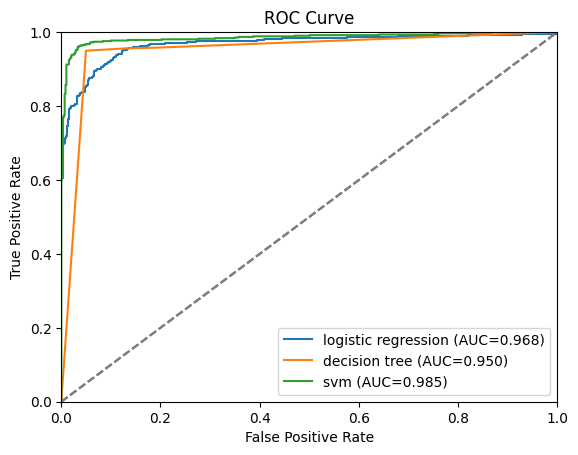

In [19]:
## plot roc curve
plt.figure()
name = ['logistic regression','decision tree','svm']
for i,prob in enumerate(predprob):
    fpr,tpr,thresholds = roc_curve(y_test, prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, label='{} (AUC={:.3f})'.format(name[i],auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], '--', color = 'grey')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

plt.show()

In [21]:
## show the performance of these three algorithms.
res = pd.DataFrame(data=res,columns=['accuracy','precision','recall','f1 score'],index=['logistic regression','decision tree','svm'])
res

,accuracy,precision,recall,f1 score
logistic regression,0.9125,0.932318,0.894481,0.913007
decision tree,0.9500,0.952769,0.949675,0.951220
svm,0.9575,0.971619,0.944805,0.958025


In [66]:
## finally training the model on the full labeled dataset and compute the labels for testing dataset.
best_svm.fit(x_full,y_full)
pred = best_svm.predict(test_full)
out = test_bin.copy()
out[128] = pred
out.to_csv("TestingResultsBinary.csv", index=False)

In [67]:
out.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,12.118057,131810.1804,-107.847846,131183.3486,132.146986,131860.3269,10.089787,370.79775,-109.664122,369.88220,...,0,0,0,0,0,0,0,0,0,1
1,12.049302,131810.1804,-107.922330,131183.3486,132.066772,131860.3269,9.986654,370.79775,-109.899035,370.61464,...,0,0,0,0,0,0,0,0,0,1
2,12.043573,131810.1804,-107.928060,131183.3486,132.061042,131860.3269,9.958006,370.79775,-109.887576,370.61464,...,0,0,0,0,0,0,0,0,0,1
3,12.037843,131810.1804,-107.939519,131183.3486,132.061042,131860.3269,9.980925,370.79775,-109.870387,370.61464,...,0,0,0,0,0,0,0,0,0,1
4,11.946170,131810.1804,-108.031192,131183.3486,131.963639,131860.3269,9.860604,370.79775,-110.059463,370.79775,...,0,0,0,0,0,0,0,0,0,1


In [68]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)